<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/62_Pro_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%A2%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация договоров при помощи: **Linear Conv1D нейросеть**, **PSPnet**, **UNET**



# Сегментация текстов

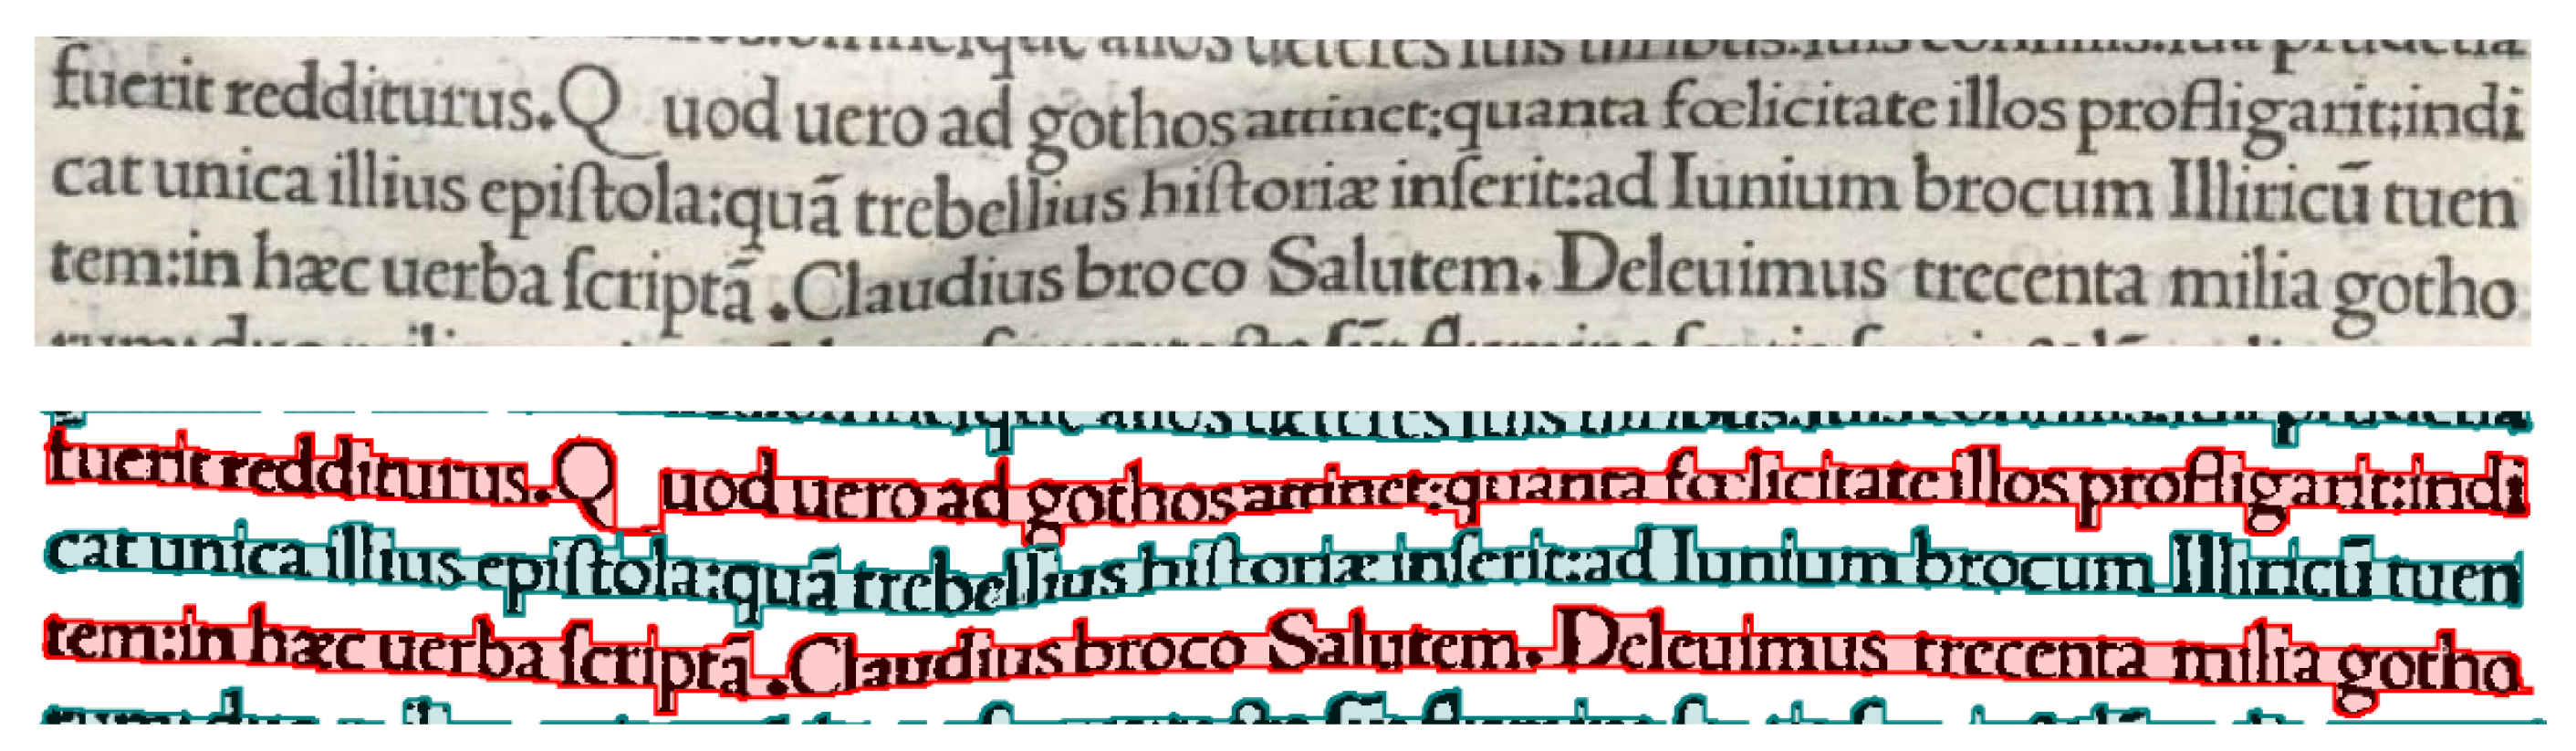

# Импорт библиотек

https://youtu.be/wdi8HYhgGj0?t=97

In [ ]:
!pip install -q pymorphy2 # установка лемматизатора pymorphy2

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 9.3 MB/s 


In [ ]:
import numpy as np # Библиотека для работы с массивами данных
from tensorflow.keras.models import Model, load_model # Импортируем Model, load_model - метод, что загружает предобученную сеть
import re # Имортируем чтобы работать с строками
from tensorflow.keras.preprocessing.text import Tokenizer # Метод, который поволяет работать с текстами и конвертирует их в последовательности (индексов)
# Импорт слоёв нейронных сетей
from tensorflow.keras.layers import Dense, Reshape, Embedding, Input, Flatten, concatenate, Activation, MaxPooling1D, Conv1D, Conv2D, BatchNormalization, Dropout, Conv2DTranspose, Conv1DTranspose, Lambda
from tensorflow.keras import backend as K # Импортируем, чтобы высчитать dice_coef(ошибку)
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы
from tensorflow.keras import utils # Импортируем для работы с категориальными данными
import tensorflow
from google.colab import files # Импорт для работы с файлами
import matplotlib.pyplot as plt # Импорт для отрисовывания графиков
from gensim.models import word2vec # Импортируем gensim
import os # Импортируем для работы с системными файлами
import pandas as pd # Импортируем для работы с Массивами данных(таблицами - Датафреймами)
import time # Имортируем, чтобы высчитать время работы каких-либо процессов
import nltk #Natural language toolkit - Инструментарий естественного языка
from nltk.stem import WordNetLemmatizer  # Импортируем для работы с леммами
import pymorphy2 # Импортируем для работы с леммами

nltk.download('wordnet') # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции для работы с текстами

https://youtu.be/wdi8HYhgGj0?t=126

Превращаем договоры в листы слов

# **Лист тегов и их значений**
https://youtu.be/wdi8HYhgGj0?t=48
**`<s1>`** - Условия

**`<s2>`** - Запреты

**`<s3>`** - Цена

**`<s4>`** - Условия (относительно дат)

**`<s5>`** - Штрафы

**`<s6>`** - Адреса и местоположения


In [ ]:
# Считываем текст из файла и удаляем пунктуационные знаки препинания и еще дополнительные ненужные нам знаки
def readText(fileName):
  f = open(fileName, 'r') # Открываем наш файл и считываем наши данные
  text = f.read() # Помещаем наш текст в переменную
  # Определяем, какие знаки будут удалены
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']

  for dS in delSymbols: # Каждый знак из нашего списка будет удалён из списка
    text = text.replace(dS, " ") # Удаляем знак, посредством замены этого знака на пробел

  # Выискиваем дополнительные знаки в текстах посредством паттернов и определяем на что их заменять
  text = re.sub("[.]", " ", text)
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # split  метод разделит текст на последовательность слов при помощи пробелов
  # (а их может быть в одном месте очень много после наших удалений знаков), которые будет являться разделителями.
  # Используя join метод, мы обратно соберём последовательности слов в текст
  text = ' '.join(text.split()) 

  text = text.lower() # Конвертируем текст к нижнему регистру
  return text # Возвращаем текст

# Конвертируем исходный текст в лист слов с начальной формой 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Инициализируем инструмент для работы с морфемами и более
  words = text.split(' ') #  Разделяем текст по средством пробелов
  docs = [morph.parse(word)[0].normal_form for word in words] # Превращаем каждое слово в элемент списка
  return docs # Возвращаем полученный документ

# Read the data

https://youtu.be/wdi8HYhgGj0?t=330



In [ ]:
directory = '/content/drive/MyDrive/Базы/Договоры 432/' # Путь к папке с договорами
os.listdir(directory)[250:255] # Выводим на экран название 5 договоров

['dogovor-zaloga-s-peredachej-predmeta-zaloga-zalogoderzhatelyu.txt',
 'dogovor-zaloga-privatizirovannoy-kvartiri.txt',
 'dogovor-zaloga-imuschestvennih-prav.txt',
 'dogovor-zaloga-imuschestva.txt',
 'dogovor-zaloga-imuschestva-kvartiri.txt']

In [ ]:
print('Всего', len(os.listdir(directory)), 'договора')

Всего 432 договора


In [ ]:
curTime = time.time() # Запоминаем текущее время
agreements = [] # Лист, что будет хранить все наши договоры
for filename in os.listdir(directory): # Проходимся по каждому договору
  txt = readText(directory + filename) # Считываем текст в договоре
  if txt != '': # Если договор не пустой
    agreements.append(readText(directory + filename)) # Превращаем файл в текст и добавляем его в agreements
print('Загрузка файла заняла: ', round(time.time() - curTime, 2), 'с.')

Загрузка файла заняла:  4.28 с.


In [ ]:
n = 3
print(os.listdir(directory)[n]) # Выводим названия n-ого договора
agreements[n]                   # Текст n-ого договора

2 (2).txt


'договор благотворительного пожертвования целевое использование г г в лице действующего на основании именуемый в дальнейшем благотворитель с одной стороны и в лице действующего на основании именуемый в дальнейшем благополучатель с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 общие положения 1 1 <s3> благотворитель передает благополучателю денежные средства благотворительное пожертвование для реализации благотворительной программы </s3> 1 2 цели программы 1 3 программа и бюджет прилагаются к договору и являются неотъемлемой частью настоящего договора 1 4 <s4> настоящий договор начинает действовать с года датой окончания договора является года настоящий договор вступает в силу с момента заключения и заканчивается после выполнения принятых сторонами на себя обязательств в соответствии с условиями договора </s4> 2 порядок предоставления и расходования пожертвования 2 1 <s3> общая сумма благотворительного пожертвования сост

In [ ]:
docs_full = [] # Лист будет содержать все договоры как списки документов
curTime = time.time() # Запоминаем текущее время
for i in range(len(agreements)): # Проходимся по каждому договору
  docs_full.append(text2Words(agreements[i])) # Превращаем договор в лист слов и добавляем его в docs_full
print('Превращение заняло: ', round(time.time() - curTime, 2), 's.')

Превращение заняло:  167.29 s.


In [ ]:
print(len(docs_full)) # Выводим число записей в наборе данных 

# Выбираем итоговое количество данных для обучающей/проверочной и тестовой выборках
docs = docs_full[0:-10]
docsToTest = docs_full[-10:]

422


In [ ]:
print('Число текстов в для тестовой проверки в конце ноутбука:', len(docsToTest)) 
print('Число договоров для обучающей и проверочной выборках:',len(docs)) 
print('Число слов в первом договоре:', len(docs[1]))

Число текстов в для тестовой проверки в конце ноутбука: 10
Число договоров для обучающей и проверочной выборках: 412
Число слов в первом договоре: 860


In [ ]:
print('Пример текста обычного:')
print(agreements[4][:62], '\n')
print('Тот же текст, но представленный ввиде лемм:')
print(docs[4][:10])

Пример текста обычного:
договор бартера г г в лице действующего на основании именуемый 

Тот же текст, но представленный ввиде лемм:
['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать']


# Превращение текстов в последовaтельность индексов: создание xTrain
https://youtu.be/wdi8HYhgGj0?t=594

In [ ]:
# lower=True - приводит к нижнему регистру все слова
# char_level=False - говорит токенайзеру не инициализировать отдельно каждую букву как токен  
tokenizer = Tokenizer(lower=True, filters = '', char_level=False)

tokenizer.fit_on_texts(docs_full) # Скармливаем тексты токенайзеру
clean_voc = {}                    # Создаем пустой словарь

for item in tokenizer.word_index.items(): # Превращаем лист в словарь
  clean_voc[item[0]] = item[1]            # Мы меняем местами элеметны кортежа

In [ ]:
print('Словарь все слов по их частотноти:') 
print(clean_voc, '\n')
print('Длина словаря:', len(clean_voc))

tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Словарь все слов по их частотноти:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'право': 24, 'работа': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'лицо': 35, 'имущество': 36, 'день': 37, 'действовать': 38, 'арендатор': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'п': 45, 'дальнейший': 46, 'работник': 47, 'который': 48, 'а': 49, 'обязательство': 50, 'страховой': 51, 'законодательство': 52, 'порядок': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'арендодатель': 57, 'свой': 58, 'счёт': 59, 'соответствие': 60, 'указанный': 61, 'именовать': 62, 'мочь': 63, 'из': 64, 'основание': 65, 'обязанность': 66, 'обязать': 67, 'исполнение': 68, 'один': 69, 'страховщик': 70, 'страхователь': 71, 'иной': 72, 'год': 73, 'до': 7

In [ ]:
# Превращает текст в последовательность индексов согласно словарю частотности
tok_agreem = tokenizer.texts_to_sequences(docs) # Обучающий выборка в последовтельность индексов

print("Взгляните на фрагмент обучающей выборки:")
print("Исходный текст:              ", docs[4][:20])
print("Тот же текст, но как последовательность индексов: ", tok_agreem[4][:20], '\n')

Взгляните на фрагмент обучающей выборки:
Исходный текст:               ['договор', 'бартер', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'сторона', '1', 'с', 'один', 'сторона', 'и', 'в', 'лицо']
Тот же текст, но как последовательность индексов:  [2, 4233, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 7, 5, 8, 69, 7, 3, 1, 35] 



# Создание yTrain

https://youtu.be/wdi8HYhgGj0?t=695

Каждый индекс (слово) из договора будет соответсвовать вектору, чьи элементы соотвествуют категориям тегов

In [ ]:
#  Собираем лист индексов и их мультилейбл класссификации
def getXYSamples(tok_agreem, tags_index):
  tags01 = [] # лист тегов
  indices = [] # лист индексов
 
  for agreement in tok_agreem: # Проходимся по каждому договору-листу
    tag_place = [0, 0, 0, 0, 0, 0, 1] # создаём вектор [0,0,0,0,0,0,1] 7 классов
    for ex in agreement: # Проходимся по каждому слову из договора
        if ex in tags_index: # Проверяем, если индекс слова соотвествует индексу одного из тегов
          place = np.argwhere(tags_index==ex) # Запоминаем позицию тега в этом листе тегов
          if len(place)!=0: # Проверяем, если тек в самом деле есть
            if place[0][0]<6: # Первые 6 тегов - открывающие теги
              tag_place[place[0][0]] = 1    # устанавливаем значение 1 
              tag_place[6] = 0             
            else: 
              tag_place[place[0][0] - 6] = 0  # Все остальные теги закрывающие, так что мы меняем в соответсвующем месте в векторе на 0
              tag_place[6] = 1
                  
        else:          
          tags01.append(tag_place.copy()) # Добавляем в наш лист тегов новые вектора мульти-лейбл классификации. 
                                          # В конце концов у нас будет большой лист всех вектор-тегов
          indices.append(ex) # Добавляем индекс-слова в лист индексов

  return indices, tags01

# Получаем лист слов из листа индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) #  Берёт ключ и значение из словаря и меняет их местами
  docs = [reverse_word_map.get(letter) for letter in x] # Положим их в лист
  return docs # Возвращает текст

In [ ]:
#<s1> - Условия договора
#<s2> - Запреты
#<s3> - Стоимость
#<s4> - Условия (относительно дат)
#<s5> - Штрафы
#<s6> - Адреса и местоположения

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Лист открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Лист закрывающих тегов
tags_index.extend(closetags) # конкатенируем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем инексы всех тегов из словря частотности
print('Индексы всех тегов:', tags_index)

Индексы всех тегов: [ 12 341  22  27 117 278  13 352  23  28 118 273]


In [ ]:
curTime = time.time()
xData, yData = getXYSamples(tok_agreem,tags_index) # Получаем теги и создаём листы с ними
decoded_text = reverseIndex(clean_voc, xData) # Чтобы создать лист для эмбеддинга, нам нужно превратить лист индексов обратно в лист слов
print('Превращение заняло: ', round(time.time() - curTime, 2), 'с.')

Превращение заняло:  2.46 с.


In [ ]:
print('длина xData:', len(xData))
print('длина yData:', len(yData))

print('Посмотрим на исходные слова: ', docs[0][50:80])
print('Сдекодированые слова:', decoded_text[50:80])
print('Часть xData:     ', xData[50:80])
print('Часть yData:     ', yData[50:80])

длина xData: 409700
длина yData: 409700
Посмотрим на исходные слова:  ['1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '</s1>', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по']
Сдекодированые слова: ['1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор']
Часть xData:      [5, 112, 2, 5, 5, 6, 9, 2, 224, 115, 918, 319, 125, 18, 250, 3, 546, 244, 319, 1, 396, 5, 4, 250, 304, 10, 162, 6, 9, 2]
Часть yData:      [[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0

# Разделение выборки на окна

https://youtu.be/wdi8HYhgGj0?t=1310

In [ ]:
# Создание выборки из индексов
def getSetFromIndices(wordIndices, xLen, step): 
  xBatch = [] # Лист, хранящий фрагменты текста
  wordsLen = len(wordIndices) # получаем длину текста
  index = 0 #  стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса и окна меньше или равно чем число слов в выборке
    xBatch.append(wordIndices[index:index+xLen]) # Добавляем X в лист, что содержит наши фрагменты(окна) текста
    index += step # Смещаем наше индекс на наш шаг(step)

  return xBatch #  Лист фрагментов текста

In [ ]:
xLen = 256 # Длина каждого окна
step = 30 # шаг 
embeddingSize = 300 # Число измерений вектор-пространства для каждого нашего слова 

In [ ]:
#  Генерируем выборки с параметрами наших окон
xTrain = getSetFromIndices(decoded_text, xLen, step) # Последовательность индексов с окном xLen слов !!!decoded_text - итого все слова, не индексы, вообще все слова
yTrain = getSetFromIndices(yData, xLen, step) # Последовательность индексов с окном xLen от тегов


In [ ]:
print('Длина xTrain:', len(xTrain))
print('Длина yTrain:', len(yTrain))
print('Длина примера из xTrain:',len(xTrain[0]))
print('Длина примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[1][:10])

Длина xTrain: 13649
Длина yTrain: 13649
Длина примера из xTrain: 256
Длина примера из yTrain: 256 

Пример xTrain ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь', 'по

In [ ]:
# Превращаем текст в последовательность индексов согласно словарю частотности
tok_agreemTest = tokenizer.texts_to_sequences(docsToTest) # Обучающий текст в индексы

print("Посмотрим на фрагмент тестового текста:")
print("Исходный текст:              ", docsToTest[4][:20])
print("Тот же текст, но как последовательность индексов: ", tok_agreemTest[4][:20], '\n')

xDataTest, yDataTest = getXYSamples(tok_agreemTest,tags_index) # Распознаём теги и создаём лист, что их хранят
decoded_text = reverseIndex(clean_voc, xDataTest) # Чтобы создать лист для эмбеддинга, нам нужно превратить лист индексов обратно в лист слов
print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))

print('Сдекодированные текст:', decoded_text[50:80])
print('Часть xDataTest:     ', xDataTest[50:80])
print('Часть yDataTest:     ', yDataTest[50:80])

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300 # Число измерений вектор-пространства для каждого нашего слова 

# Генерируем выборки с определёнными параметрами
xTest = getSetFromIndices(decoded_text, xLen, step) # Последовательность индексов с окном Xlen слов
yTest = getSetFromIndices(yDataTest, xLen, step) # # Последовательность индексов с окном Xlen от тегов

print('Длина xTest:', len(xTest))
print('Длина yTest:', len(yTest))
print('Длина примера xTest:',len(xTest[0]))
print('Длина примера yTest:',len(yTest[0]), '\n')
print('Пример xTest', xTest[0])
print('Пример yTest', yTest[0], '\n')

print('Первый пример xTest:', xTest[0][step-5:step+5])
print('Второй пример xTest:', xTest[1][:10])

Посмотрим на фрагмент тестового текста:
Исходный текст:               ['трудовой', 'контракт', 'с', 'руководитель', 'кадровый', 'служба', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'общество', 'с', 'один', 'сторона']
Тот же текст, но как последовательность индексов:  [79, 187, 8, 675, 4217, 640, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 146, 8, 69, 7] 

Длина xDataTest: 11750
Длина yDataTest: 11750
Сдекодированные текст: ['положение', '1', '1', 'настоящий', 'договор', 'заключить', 'между', 'в', 'лицо', 'председатель', 'совет', 'директор', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин', 'россия', 'именовать', 'в', 'дальнейший', 'директор', '1', '2', 'договор', 'регулировать']
Часть xDataTest:      [209, 5, 5, 9, 2, 109, 182, 1, 35, 1902, 537, 217, 62, 1, 46, 129, 8, 69, 7, 3, 265, 941, 62, 1, 46, 217, 5, 4, 2, 1060]
Часть yDataTest:      [[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1

# Функции создания моделей
https://youtu.be/wdi8HYhgGj0?t=1574

## Функция, что считает ошибку
https://youtu.be/wdi8HYhgGj0?t=1566

In [ ]:
# Функция нужна для точности
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

##**UNET**
https://youtu.be/wdi8HYhgGj0?t=1769

In [ ]:
# Функция по созданию сети UNET
def create_unet(k = 1, num_classes = 7, input_shape= (256, 300)):
    img_input = Input(input_shape)

    # Блок 1
    x = Conv1D(64 * k , 3, padding='same')(img_input)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(512 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(1e-4), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

# Создание xTrain и  yTrain используя Word2Vec GENSIM

https://youtu.be/wdi8HYhgGj0?t=1830


In [ ]:
def pad_zeros(phrase, xLen = 256): # Функция для дополнением нулями
  while len(phrase) < xLen: # Пока сущестующий размер меньше чем требуемый 
    phrase.append([0] * embeddingSize) # Продолжаем добавлять элементы(нули) в фразу(zero-pad)  
  if len(phrase) > xLen: # В противном случае, если фраза больше чем  требуемый размер
    phrase = phrase[:xLen] # Берём только требуемое число элементов
  return phrase # Возвращаем обработанную фразу

# Создаём выборку
def getSets(model, senI, tagI):
  xVector = [] # Лист будет содержать ембеддинг представление на каждый индекс
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому лист-тексту
    tmp=[]
    for word in text: # Проходимся по кажому слову лист-текста
      try: # Если слово есть в модели (словарь не слишком мал), мы не получим ошибку
        tmp.append(model.wv[word])
      except: # В противном случае пропустим слово
        pass

    xVector.append(pad_zeros(tmp, xLen))
  temp = np.array(xVector)
  return np.array(xVector, dtype = np.float32), np.array(tagI)

In [ ]:
# Подаём лист листов слов в word2vec для обучающей выборке
# size = embeddingSize - Размер ембеддинга
# window = 10 -  минимальное расстояния между эмбеддинг словами
# min_count = 1 - Игнорируем все слова с частотой меньше чем 1
# workers = 10 -  Число потоков на обучение эмбеддинга
# iter = 20 -  Число эпох на обучение эмбеддинга
# max_vocab_size = 1e5 -  Число слов в "словарном запасе" word2vec
curTime = time.time()

modelGENSIM = word2vec.Word2Vec(xTrain + xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10, max_vocab_size = 1e5 )
print('Обучение GENSIM модели заняло: ', round(time.time() - curTime, 2), 'с.')

Обучение GENSIM модели заняло:  19.93 с.


In [ ]:
modelGENSIM.wv['договор'] # Пример превращения слова в вектор при помощи GENSIM

array([-2.6661885e+00,  2.6350086e+00,  1.2704948e+00, -7.1471143e-01,
        5.0038618e-01, -1.3093657e+00, -9.2749900e-01,  2.1324359e-01,
       -9.2798591e-01,  1.7669562e+00, -1.8450052e+00,  1.1611488e+00,
       -1.8203786e-01,  1.0213139e+00, -3.0541307e-01,  4.7686121e-01,
        4.5726481e-01,  1.5479972e+00, -1.3382204e+00,  8.6952731e-02,
       -3.0834711e+00, -1.6890227e+00, -2.2963762e+00, -1.3925637e+00,
       -9.7796667e-01,  4.1139784e-01,  1.0704808e+00,  9.3582338e-01,
       -9.5526904e-01, -4.1417831e-01,  1.8016179e+00, -2.3685986e-01,
       -1.6253895e-01,  5.6048501e-01, -1.0487440e+00,  1.2369349e+00,
       -3.5875356e-01,  1.4087461e+00, -8.5109544e-01,  1.6020241e+00,
        6.4770901e-01, -4.2211002e-01, -6.9397813e-01,  1.8325698e+00,
        7.7697390e-01,  6.5205699e-01,  3.1847888e-01, -7.5433290e-01,
       -1.3831507e+00,  1.2915950e+00, -3.9025538e+00,  1.1451981e-01,
       -4.2332566e-01, -1.6776039e-01, -2.0822816e+00,  3.2258313e+00,
      

In [ ]:
GENSIMtrainX, GENSIMtrainY = getSets(modelGENSIM, xTrain, yTrain)
GENSIMtestX, GENSIMtestY = getSets(modelGENSIM, xTest, yTest)

In [ ]:
print('Размерности xTrain:', GENSIMtrainX.shape)
print('Размерности yTrain:', GENSIMtrainY.shape)

Размерности xTrain: (13649, 256, 300)
Размерности yTrain: (13649, 256, 7)


# Train the networks
https://youtu.be/wdi8HYhgGj0?t=2099

## **UNET**
https://youtu.be/wdi8HYhgGj0?t=2204

### Архитектура Unet, к = 1

In [ ]:
model_b_UNET = create_unet(input_shape=(xLen, embeddingSize), num_classes = 7)
model_b_UNET.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d_51 (Conv1D)             (None, 256, 64)      57664       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_57 (BatchN  (None, 256, 64)     256         ['conv1d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_57 (Activation)     (None, 256, 64)      0           ['batch_normalization_57[0]

In [ ]:
history = model_b_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=10, batch_size=128) # Feed the images divided among 2 classes to the model
model_b_UNET.save('/content/drive/MyDrive/Предобученные сети/model_b_UNET_10epochs.h5')

Epoch 1/10
107/107 [==============================] - 53s 446ms/step - loss: 1.8358 - dice_coef: 0.3461 - val_loss: 1.9988 - val_dice_coef: 0.3111
Epoch 2/10
107/107 [==============================] - 47s 444ms/step - loss: 1.3941 - dice_coef: 0.4239 - val_loss: 3.4659 - val_dice_coef: 0.3876
Epoch 3/10
107/107 [==============================] - 49s 462ms/step - loss: 1.2434 - dice_coef: 0.4621 - val_loss: 2.7660 - val_dice_coef: 0.4004
Epoch 4/10
107/107 [==============================] - 49s 453ms/step - loss: 1.1289 - dice_coef: 0.4867 - val_loss: 1.7766 - val_dice_coef: 0.4112
Epoch 5/10
107/107 [==============================] - 51s 473ms/step - loss: 1.0161 - dice_coef: 0.5006 - val_loss: 1.6719 - val_dice_coef: 0.4280
Epoch 6/10
107/107 [==============================] - 50s 471ms/step - loss: 0.9361 - dice_coef: 0.5115 - val_loss: 1.8423 - val_dice_coef: 0.4087
Epoch 7/10
107/107 [==============================] - 48s 445ms/step - loss: 0.8765 - dice_coef: 0.5237 - val_loss: 1.

In [ ]:
model_b_UNET.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=[dice_coef])
history = model_b_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=10, batch_size=128) # Feed the images divided among 2 classes to the model
model_b_UNET.save('/content/drive/MyDrive/Предобученные сети/model_b_UNET_20epochs.h5')

Epoch 1/10
107/107 [==============================] - 61s 522ms/step - loss: 0.7739 - dice_coef: 0.5324 - val_loss: 1.7367 - val_dice_coef: 0.4215
Epoch 2/10
107/107 [==============================] - 59s 550ms/step - loss: 0.7683 - dice_coef: 0.5331 - val_loss: 1.7510 - val_dice_coef: 0.4190
Epoch 3/10
107/107 [==============================] - 59s 554ms/step - loss: 0.7590 - dice_coef: 0.5335 - val_loss: 1.7527 - val_dice_coef: 0.4171
Epoch 4/10
107/107 [==============================] - 59s 548ms/step - loss: 0.7586 - dice_coef: 0.5340 - val_loss: 1.7519 - val_dice_coef: 0.4185
Epoch 5/10
107/107 [==============================] - 61s 568ms/step - loss: 0.7538 - dice_coef: 0.5341 - val_loss: 1.7541 - val_dice_coef: 0.4202
Epoch 6/10
107/107 [==============================] - 62s 584ms/step - loss: 0.7550 - dice_coef: 0.5342 - val_loss: 1.7689 - val_dice_coef: 0.4164
Epoch 7/10
107/107 [==============================] - 62s 579ms/step - loss: 0.7509 - dice_coef: 0.5344 - val_loss: 1.

In [ ]:
model_b_UNET.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=[dice_coef])
history = model_b_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=20, batch_size=128) # Feed the images divided among 2 classes to the model
model_b_UNET.save('/content/drive/MyDrive/Предобученные сети/model_b_UNET_30epochs.h5')

Epoch 1/20
107/107 [==============================] - 52s 427ms/step - loss: 0.7463 - dice_coef: 0.5327 - val_loss: 1.7592 - val_dice_coef: 0.4196
Epoch 2/20
107/107 [==============================] - 44s 412ms/step - loss: 0.7477 - dice_coef: 0.5327 - val_loss: 1.7627 - val_dice_coef: 0.4192
Epoch 3/20
107/107 [==============================] - 43s 406ms/step - loss: 0.7450 - dice_coef: 0.5325 - val_loss: 1.7632 - val_dice_coef: 0.4194
Epoch 4/20
107/107 [==============================] - 43s 401ms/step - loss: 0.7443 - dice_coef: 0.5324 - val_loss: 1.7630 - val_dice_coef: 0.4195
Epoch 5/20
107/107 [==============================] - 43s 406ms/step - loss: 0.7442 - dice_coef: 0.5324 - val_loss: 1.7639 - val_dice_coef: 0.4199
Epoch 6/20
107/107 [==============================] - 45s 422ms/step - loss: 0.7478 - dice_coef: 0.5324 - val_loss: 1.7625 - val_dice_coef: 0.4205
Epoch 7/20
107/107 [==============================] - 45s 419ms/step - loss: 0.7501 - dice_coef: 0.5322 - val_loss: 1.

### **Проверяем работу сети**

https://youtu.be/wdi8HYhgGj0?t=2244

In [ ]:
def recognizeSet(XX, YY, model, tags, length, value):
  correct_list = np.array([0] * 7) #Инициализируем массив правильных ответов в нули (сколько раз правильно определили класс)
  incorrect_list =  np.array([0] * 7)  #Инициализируем массив неправильных ответов в нули  (сколько раз неправильно определили класс)
  XX_array = XX
  YY_array = YY
  pred = model.predict(XX_array)
  pred[pred < value] = 0
  pred[pred > value] = 1

  for element in range(YY_array.shape[0]): # Проходим по всем примерам в батче
    for word in range(YY_array.shape[1]):  # Проходим по каждому слову
      for category in range(YY_array.shape[2]): # Проходим по каждой категории в слове
        if pred[element][word][category] == YY_array[element][word][category]: # Если предсказанное значение совпадает с истинным:
          correct_list[category] += 1 # Отмечаем, что мы правильно предсказали класс объекта
        else:  # Если предсказанное значение НЕ совпадает с истенным:
          incorrect_list[category] += 1 # Отмечаем, что мы не правильно предсказали класс объекта
      
  # Итоговая точность для каждого класса = кол. 100% * правильных/(кол. неправильных + кол. правильных)
  for i in range(7):
   print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
  total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
  print("Средняя точность {}%".format(total))

In [ ]:
print('Размер xTrain:', GENSIMtestX.shape)
print('Размер yTrain:', GENSIMtestY.shape)

Размер xTrain: (384, 256, 300)
Размер yTrain: (384, 256, 7)


In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
# s1 Условия
# s2 Запреты
# s3 Стоимость (услуг и прочее)
# s4 Условия (относительно дат - дедлайны)
# s5 Штрафы
# s6 Адреса и местоположения

In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET, tags, xLen, 0.1) # Проверяем UNET архитектуру

12/12 [==============================] - 1s 40ms/step
Сеть распознала категорию  'S1' с точностью в 36.39%
Сеть распознала категорию  'S2' с точностью в 17.47%
Сеть распознала категорию  'S3' с точностью в 18.37%
Сеть распознала категорию  'S4' с точностью в 13.48%
Сеть распознала категорию  'S5' с точностью в 36.18%
Сеть распознала категорию  'S6' с точностью в 3.08%
Сеть распознала категорию  'S7' с точностью в 50.04%
Средняя точность 25.0%


# Резюме

Изменен lr = 1e-4, на этапе компилляции. Существенно повысил результат. 

Изменен batch_size = 128, менее существенное изменение, ускорили процесс обучения.

Добавлен 7-ой класс, лучшая реализация в разборе ДЗ по ссылке https://colab.research.google.com/drive/1daqOBYxrk-eqrTiff2upHNvp-CQa78xV?usp=share_link

Для более существенного улучшения нужно поработать с балансом классов, т.е. сбалансировать датасет.